## 第一階段-撰寫一個2-n-1的淺層類神經網路
1. 隱藏層的神經元使用Tangent Sigmoid作為激活函數 <br>
2. 輸出層為線性函數<br>
3. 類神經網路的輸入為兩個四位數的數值，輸出則為這兩個數的總和<br>
4. 調整你的隱藏層神經元數量，並畫出一張神經元數量對30次訓練結果之誤差平均的圖。<br>
* PS1: 撰寫類神經前請先產生你的資料集，建議要有10000筆以上，接著把這個資料集切開成訓練與測試資料集。* <br>
* PS2: 不管是輸入還是輸出都要正規化到0-1之間，而產出結果時，需要把輸出反正規化到原本的空間中。*<br>

In [94]:
import numpy as np
import math
import matplotlib.pyplot as plt

# 方法

In [95]:
# FUN: 初始值
def init(n):
    global W2, W1, b1, b2, neuron_num, learning_rate
    ## 類神經網路
    # 隱藏層神經元數
    neuron_num = n

    ## 權重與偏差
    W1 = np.random.randn(neuron_num, 2)
    W2 = np.random.randn(1, neuron_num)
    b1 = np.random.randn(neuron_num)
    b2 = np.random.randn(1)
    learning_rate = 0.001

In [96]:
# FUN: 產生數據
def generateData(stage):
    if stage == 1:
        ## DATA
        # 數據數量
        data_num = 30000
        # 輸入值: (四位數, 四位數)陣列
        total_X = (np.random.rand(data_num, 2)*9998).astype(np.int32)+1
        # 輸出值: 四位數 + 四位數 陣列
        total_Y = np.sum(total_X, axis=1).reshape(-1, 1)
        # 對輸入和輸出進行正規化
        total_X, min_inputs, range_inputs = standardize(total_X)
        total_Y, min_outputs, range_outputs = standardize(total_Y)
        # 切成訓練與測試
        train_ratio = 0.7
        train_size = int(train_ratio * len(total_X))
        train_X = total_X[:train_size]
        train_Y = total_Y[:train_size]
        test_X = total_X[train_size:]
        test_Y = total_Y[train_size:]
    return train_X, train_Y, test_X, test_Y, min_outputs, range_outputs

In [97]:
# FUN: 正規化
def standardize(numArray):
    # 正規化至0到1之間
    min_val = np.min(numArray)
    range_val = np.max(numArray) - min_val
    numArr_std = (numArray - min_val) / range_val
    return numArr_std, min_val, range_val
# FUN: 反正規化
def unstandardize(numArray, min_val, range_val):
    return numArray * range_val + min_val

In [98]:
## FUN: activation function
# tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
# https://www.baeldung.com/cs/sigmoid-vs-tanh-functions
def TangentSigmoid(x):
    return np.tanh(x)

In [99]:
# FUN: 正向傳播
def forward(X0):
    # 第一層
    Z1 = np.dot(X0, W1.T) + b1
    X1 = TangentSigmoid(Z1)

    # 第二層
    Z2 = np.dot(X1, W2.T) + b2
    X2 = TangentSigmoid(Z2)

    return Z1, X1, Z2, X2

In [100]:
## 反向傳播
# FUN: Tangent Sigmoid 微分
def dTangentSigmoid(x):
    return 1 - np.power(np.tanh(x), 2)
# FUN: 計算輸出層梯度
def delta_output(Z, Y):
    return (TangentSigmoid(Z) - Y) * dTangentSigmoid(Z)
# FUN: 計算隱藏層梯度
def delta_hidden(Z, D, W):
    return dTangentSigmoid(Z) * np.dot(D, W)
# FUN: 倒傳遞
def backward(Y, Z2, Z1):
    # 計算輸出層梯度
    D2 = delta_output(Z2, Y)

    # 計算隱藏層梯度
    D1 = delta_hidden(Z1, D2, W2)

    return D2, D1

In [101]:
# FUN: 目標函數對權重微分
def deweight(D, X):
    return np.dot(D.T, X)

# FUN: 目標函數對偏差微分
def debias(D):
    return D.sum(axis=0)

In [102]:
# FUN: 參數更新
def update_paras(D2, X1, D1, X0):
    global W2, W1, b1, b2, neuron_num, learning_rate
    # 更新權重
    W2 = W2 - learning_rate * deweight(D2, X1)
    W1 = W1 - learning_rate * deweight(D1, X0)

    # 更新偏差
    b2 = b2 - learning_rate * debias(D2)
    b1 = b1 - learning_rate * debias(D1)

In [103]:
## FUN: 學習
def train(X, Y):
    # 正向傳播
    Z1, X1, Z2, X2 = forward(X)

    # 反向傳播
    D2, D1 = backward(Y, Z2, Z1)

    # 參數更新
    update_paras(D2, X1, D1, X)

In [104]:
# FUN: 預測
def predict(X):
    # -1為最後
    ans = forward(X)[-1]
    return ans

# FUN: 計算誤差
def error_function(Y, X):
    # 1/2*error^2
    a = predict(X)
    return 0.5 * ((Y - a) ** 2).sum()

In [105]:
## 執行
def exec(stage, times, max_n):
    # 保存每次訓練的誤差
    diffs = []  
    min_n = stage
    # 重複訓練
    for time in range(0, times):
        train_X, train_Y, test_X, test_Y, min_outputs, range_outputs = generateData(stage)

        for n in range(min_n, max_n+1):
            # NN
            init(n)

            ## 批次執行
            batch = 30
            epoch = 30
            for e in range(0, epoch):
                # 隨機打亂訓練資料的索引
                p = np.random.permutation(len(train_X))

                # 遍歷每個batch
                for i in range(math.ceil(len(train_X) / batch)):
                    # 取出當前batch的索引範圍
                    indice = p[i * batch:(i + 1) * batch]

                    # 根據索引範圍從原始資料中取出對應的batch資料
                    X = train_X[indice]
                    Y = train_Y[indice]

                    # 使用當前batch資料進行模型訓練
                    train(X, Y)

                 # 輸出訓練誤差
                if e % 3 == 0:
                    error = error_function(train_Y, train_X)
                    log = f'\
                    time = {time}, n = {n}, error = {error} ({e}th epoch),\n \
                    '
                    print(log)
      
            ## 對預測結果進行反正規化
            predicted_outputs = unstandardize(predict(test_X), min_outputs, range_outputs)
            origin_outputs = unstandardize(test_Y, min_outputs, range_outputs)
            ## 記錄誤差
            mean_diff = np.mean(np.abs(predicted_outputs - origin_outputs))
            if len(diffs) < n:
                diffs.append(mean_diff)
            else:
                diffs[n-1] += mean_diff
    return diffs

# 執行

In [106]:
times = 3
max_n = 3
stage = 1
diffs = exec(stage, times, max_n)
mean_diffs = [diff / times for diff in diffs]

                    time = 0, n = 1, error = 515.9185952268139 (0th epoch),
                     
                    time = 0, n = 1, error = 283.79860144343286 (3th epoch),
                     
                    time = 0, n = 1, error = 129.6158069541026 (6th epoch),
                     
                    time = 0, n = 1, error = 62.38402889038186 (9th epoch),
                     
                    time = 0, n = 1, error = 34.40988612668582 (12th epoch),
                     
                    time = 0, n = 1, error = 23.05187883986071 (15th epoch),
                     
                    time = 0, n = 1, error = 17.28649331238658 (18th epoch),
                     
                    time = 0, n = 1, error = 13.813495934790609 (21th epoch),
                     
                    time = 0, n = 1, error = 11.517891332348789 (24th epoch),
                     
                    time = 0, n = 1, error = 9.881714757803483 (27th epoch),
                     
           

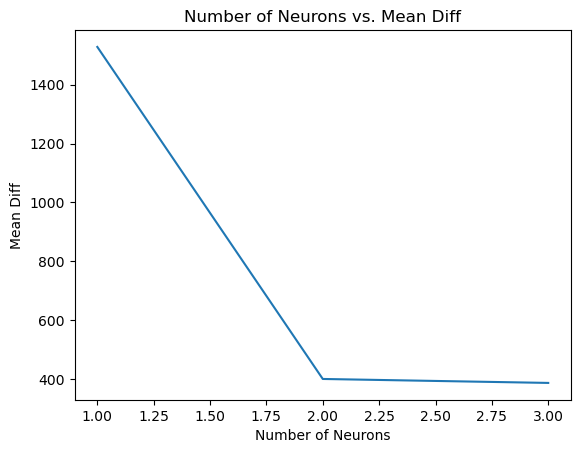

end


In [107]:
## 繪圖
n_list = list(range(1, max_n+1))
plt.plot(n_list, mean_diffs)
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Diff')
plt.title('Number of Neurons vs. Mean Diff')
plt.show()
print('end')